Shape: (16, 3)


,Person,AVG Reaction Time,Accuracy
0,1st,1.05,98.30%
1,2nd,1.50,97.50%
2,3rd,1.34,97.80%
3,4th,1.39,97.50%
4,5th,1.57,96.70%
5,6th,1.07,98.20%
6,7th,1.65,97.30%
7,8th,1.08,98.50%
8,9th,1.79,96.80%
9,10th,1.22,98.00%


Final feature count: 3
Labels used for training (integers): [0 1 2]
Mapping:  {'High': 0, 'Low': 1, 'Medium': 2}

Train/Test sizes: (12, 3) (4, 3)
Class distribution in train: {0: 6, 1: 1, 2: 5}
Class distribution in test: {0: 2, 1: 1, 2: 1}

--- Training Neural Network (MLPClassifier) ---
NN Accuracy: 0.5
NN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1

    accuracy                           0.50         4
   macro avg       0.44      0.50      0.39         4
weighted avg       0.58      0.50      0.46         4



c:\Users\Refat\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

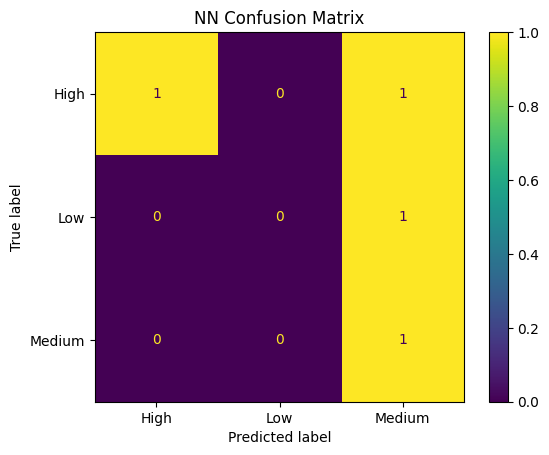


--- Training Random Forest Classifier ---
RF Accuracy: 0.5
RF Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1

    accuracy                           0.50         4
   macro avg       0.44      0.50      0.39         4
weighted avg       0.58      0.50      0.46         4



<Figure size 640x480 with 0 Axes>

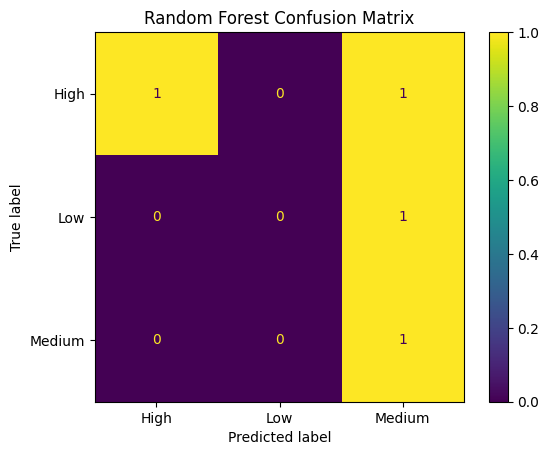


--- Training XGBoost Classifier ---
XGBoost Accuracy: 0.5
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1

    accuracy                           0.50         4
   macro avg       0.44      0.50      0.39         4
weighted avg       0.58      0.50      0.46         4



<Figure size 640x480 with 0 Axes>

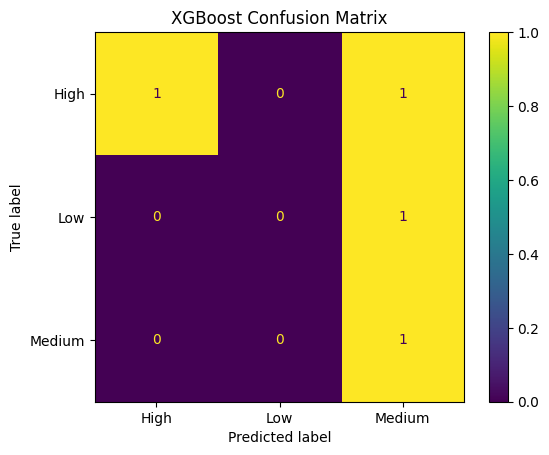

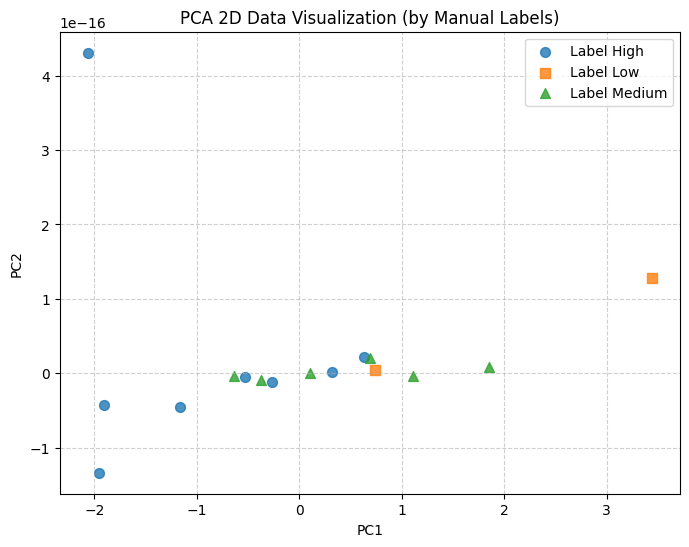

Saved models to project folder.


In [ ]:
# ==============================
# Mini Project 2 - Classification with Manual Labels
# ==============================

# Import required libraries
import os
import numpy as np
import pandas as pd

# Preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ML models
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics & Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# Make sure pandas shows all rows (useful for small datasets)
pd.set_option('display.max_rows', None)

# ==============================
# Define file paths
# ==============================
base_dir = r"E:\North South University\Semester 10\CSE445\Mini_Project_2"
csv_path = os.path.join(base_dir, "data.csv")
output_dir = os.path.join(base_dir, "output")
os.makedirs(output_dir, exist_ok=True)   # Create output folder if it doesn’t exist

# ==============================
# Load dataset
# ==============================
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at: {csv_path}")

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df)

# ==============================
# Manual labeling from accuracy column
# ==============================
label_column = df.columns[-1]   # Assume last column is accuracy
df[label_column] = df[label_column].astype(str).str.replace('%', '').astype(float)

# Create bins to categorize accuracy into Low, Medium, High
bins = [0, 96.0, 97.5, 100]
labels = ["Low", "Medium", "High"]
df['binned_label'] = pd.cut(df[label_column], bins=bins, labels=labels, right=False)

# ==============================
# Feature Engineering
# ==============================
# Drop label columns and keep numeric features only
df_features = df.drop(columns=[label_column, 'binned_label']).select_dtypes(include=[np.number]).copy()
df_labels = df['binned_label']

if df_features.shape[1] == 0:
    raise ValueError("No numeric feature columns found.")

# Handle missing values (if any) using median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(df_features)
X_imputed_df = pd.DataFrame(X_imputed, columns=df_features.columns)

# Add extra statistical features: mean and standard deviation per row
X_imputed_df['mean_feature'] = X_imputed_df.mean(axis=1)
X_imputed_df['std_feature'] = X_imputed_df.std(axis=1)

# Scale features (important for NN and distance-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed_df)

# Encode labels (Low, Medium, High → 0, 1, 2)
le = LabelEncoder()
y = le.fit_transform(df_labels.values)

print("Final feature count:", X_imputed_df.shape[1])
print("Labels used for training (integers):", np.unique(y))
print("Mapping: ", dict(zip(le.classes_, le.transform(le.classes_))))

# ==============================
# Train/Test Split
# ==============================
stratify_labels = y if min(np.bincount(y)) >= 2 else None
test_size = 0.25 if len(X_scaled) >= 8 else 0.33

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=42, stratify=stratify_labels
)

print("\nTrain/Test sizes:", X_train.shape, X_test.shape)
print("Class distribution in train:", {c:int((y_train==c).sum()) for c in np.unique(y_train)})
print("Class distribution in test:", {c:int((y_test==c).sum()) for c in np.unique(y_test)})

# ==============================
# Neural Network (MLPClassifier)
# ==============================
print("\n--- Training Neural Network (MLPClassifier) ---")
nn_clf = MLPClassifier(random_state=42, max_iter=500)
nn_clf.fit(X_train, y_train)
nn_pred = nn_clf.predict(X_test)

print("NN Accuracy:", accuracy_score(y_test, nn_pred))
print("NN Classification Report:\n", classification_report(y_test, nn_pred, zero_division=0))

# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, nn_pred, labels=np.sort(np.unique(y)))
disp_nn = ConfusionMatrixDisplay(cm_nn, display_labels=le.inverse_transform(np.sort(np.unique(y))))
plt.figure()
disp_nn.plot(values_format="d")
plt.title("NN Confusion Matrix")
plt.savefig(os.path.join(output_dir, "Confusion_Matrix_NN.jpg"))
plt.show()

# ==============================
# Random Forest Classifier
# ==============================
print("\n--- Training Random Forest Classifier ---")
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, rf_pred))
print("RF Classification Report:\n", classification_report(y_test, rf_pred, zero_division=0))

# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, rf_pred, labels=np.sort(np.unique(y)))
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=le.inverse_transform(np.sort(np.unique(y))))
plt.figure()
disp_rf.plot(values_format="d")
plt.title("Random Forest Confusion Matrix")
plt.savefig(os.path.join(output_dir, "Confusion_Matrix_RF.jpg"))
plt.show()

# ==============================
# XGBoost Classifier
# ==============================
print("\n--- Training XGBoost Classifier ---")
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred, zero_division=0))

# Confusion Matrix for XGB
cm_xgb = confusion_matrix(y_test, xgb_pred, labels=np.sort(np.unique(y)))
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=le.inverse_transform(np.sort(np.unique(y))))
plt.figure()
disp_xgb.plot(values_format="d")
plt.title("XGBoost Confusion Matrix")
plt.savefig(os.path.join(output_dir, "Confusion_Matrix_XGBoost.jpg"))
plt.show()

# ==============================
# PCA Visualization
# ==============================
if X_scaled.shape[1] > 1:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'D', 'X', 'P']
    
    for i, label in enumerate(np.unique(y)):
        plt.scatter(
            X_pca[y==label,0], 
            X_pca[y==label,1], 
            label=f"Label {le.inverse_transform([label])[0]}",
            marker=markers[i % len(markers)],
            s=50,
            alpha=0.8
        )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA 2D Data Visualization (by Manual Labels)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(output_dir, "Data_Visualize.jpg"))
    plt.show()

# ==============================
# Save Models
# ==============================
joblib.dump(nn_clf, os.path.join(output_dir, "nn_model.joblib"))
joblib.dump(rf_clf, os.path.join(output_dir, "rf_model.joblib"))
joblib.dump(xgb_clf, os.path.join(output_dir, "xgb_model.joblib"))
print("Saved models to project folder.")
